In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder.appName("CryptoDataProcessing").getOrCreate()

# Load the dataset
file_path = "/content/cryptodata.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows
data.show(10)

+----------+-------+-------+-------+-------+-------+-----------+-----+-------+
| Timestamp|   Open|   High|    Low|  Close|   VWAP|     Volume|Count| Crypto|
+----------+-------+-------+-------+-------+-------+-----------+-----+-------+
|23/02/2023|24187.7|24602.8|23615.3|23942.4|24159.9|5276.981508|36426|Bitcoin|
|24/02/2023|23946.4|24134.3|22800.8|23193.8|23430.0|4096.384087|38219|Bitcoin|
|25/02/2023|23193.7|23224.9|22739.9|23167.3|23021.4|1909.525231|23294|Bitcoin|
|26/02/2023|23167.3|23685.1|23066.7|23564.5|23443.1|2684.162416|24886|Bitcoin|
|27/02/2023|23564.4|23885.4|23108.4|23494.4|23480.9|3324.941853|31007|Bitcoin|
|28/02/2023|23491.1|23599.0|23042.0|23133.2|23346.2|2635.875664|32108|Bitcoin|
|01/03/2023|23133.2|23977.0|23044.0|23634.9|23634.1| 3268.56246|35801|Bitcoin|
|02/03/2023|23633.7|23808.0|23202.0|23466.5|23452.8|2933.027468|29963|Bitcoin|
|03/03/2023|23466.6|23478.5|22000.0|22356.1|22451.0|4394.078048|46587|Bitcoin|
|04/03/2023|22356.0|22401.0|22168.5|22348.5|22312.0|

In [ ]:
data.describe().show()

+-------+----------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-------+
|summary| Timestamp|              Open|              High|               Low|             Close|             VWAP|              Volume|             Count| Crypto|
+-------+----------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-------+
|  count|      7200|              7200|              7200|              7200|              7200|             7200|                7200|              7200|   7200|
|   mean|      NULL| 5501.054581955667| 5610.938314598394| 5393.560796891366|  5511.41528485695|5506.842510191699|1.1838204159383606E7|11750.448888888888|   NULL|
| stddev|      NULL|17308.940411515592|17659.628737152332|16965.060002047132|17341.481353411622|17328.63441082963| 4.225929494178284E7|15058.910998870328|   NULL|
|    min|01/01/2024|  

Step 2: Initial Exploration and Cleaning

Drop duplicates.

Handle null or missing values.

In [ ]:
# Count duplicates
duplicate_count = data.count() - data.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, when

# Count null values for each column
null_counts = data.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in data.columns])

# Show the null counts
null_counts.show()


+---------+----+----+---+-----+----+------+-----+------+
|Timestamp|Open|High|Low|Close|VWAP|Volume|Count|Crypto|
+---------+----+----+---+-----+----+------+-----+------+
|        0|   0|   0|  0|    0|   0|     0|    0|     0|
+---------+----+----+---+-----+----+------+-----+------+



In [ ]:
data.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VWAP: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Crypto: string (nullable = true)



In [ ]:
data.select("Timestamp").show(10, truncate=False)

+----------+
|Timestamp |
+----------+
|23/02/2023|
|24/02/2023|
|25/02/2023|
|26/02/2023|
|27/02/2023|
|28/02/2023|
|01/03/2023|
|02/03/2023|
|03/03/2023|
|04/03/2023|
+----------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import to_date, col

# Convert Timestamp to Date format
data = data.withColumn("Timestamp", to_date(col("Timestamp"), "dd/MM/yyyy"))

# Verify
data.select("Timestamp").show(10, truncate=False)

+----------+
|Timestamp |
+----------+
|2023-02-23|
|2023-02-24|
|2023-02-25|
|2023-02-26|
|2023-02-27|
|2023-02-28|
|2023-03-01|
|2023-03-02|
|2023-03-03|
|2023-03-04|
+----------+
only showing top 10 rows



In [ ]:
data.printSchema()

root
 |-- Timestamp: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VWAP: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Crypto: string (nullable = true)



Data Preprocessing

In [ ]:
from pyspark.sql.functions import expr

# Add derived columns
data = data.withColumn("Volatility", col("High") - col("Low"))
data = data.withColumn("Price_Change", col("Close") - col("Open"))

# Show data with new columns
data.show(5)

+----------+-------+-------+-------+-------+-------+-----------+-----+-------+-----------------+-------------------+
| Timestamp|   Open|   High|    Low|  Close|   VWAP|     Volume|Count| Crypto|       Volatility|       Price_Change|
+----------+-------+-------+-------+-------+-------+-----------+-----+-------+-----------------+-------------------+
|2023-02-23|24187.7|24602.8|23615.3|23942.4|24159.9|5276.981508|36426|Bitcoin|            987.5|-245.29999999999927|
|2023-02-24|23946.4|24134.3|22800.8|23193.8|23430.0|4096.384087|38219|Bitcoin|           1333.5| -752.6000000000022|
|2023-02-25|23193.7|23224.9|22739.9|23167.3|23021.4|1909.525231|23294|Bitcoin|            485.0|-26.400000000001455|
|2023-02-26|23167.3|23685.1|23066.7|23564.5|23443.1|2684.162416|24886|Bitcoin|618.3999999999978|  397.2000000000007|
|2023-02-27|23564.4|23885.4|23108.4|23494.4|23480.9|3324.941853|31007|Bitcoin|            777.0|              -70.0|
+----------+-------+-------+-------+-------+-------+-----------+

Feature Engineering

RSI Implementation

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, lag, when, avg, lit

# Define a 14-period rolling window
window_spec = Window.partitionBy("Crypto").orderBy("Timestamp").rowsBetween(-13, 0)

# Compute Price Change (Handling NULL Values)
data = data.withColumn(
    "Price_Change",
    when(lag("Close").over(Window.partitionBy("Crypto").orderBy("Timestamp")).isNull(), lit(0))
    .otherwise(col("Close") - lag("Close").over(Window.partitionBy("Crypto").orderBy("Timestamp")))
)

# Compute Rolling Average Gain & Loss over 14 periods
data = data.withColumn("Avg_Gain", avg(when(col("Price_Change") > 0, col("Price_Change")).otherwise(0)).over(window_spec))
data = data.withColumn("Avg_Loss", avg(when(col("Price_Change") < 0, -col("Price_Change")).otherwise(0)).over(window_spec))

# Compute Relative Strength (RS) and RSI (Handle Division by Zero)
data = data.withColumn("RS", when(col("Avg_Loss") == 0, lit(0)).otherwise(col("Avg_Gain") / col("Avg_Loss")))
data = data.withColumn("RSI", when(col("Avg_Loss") == 0, lit(100)).otherwise(100 - (100 / (1 + col("RS")))))

In [ ]:
from pyspark.sql.functions import col

data.select("Crypto", "Timestamp", "Close", "RSI").filter(
    col("Timestamp").isNull() | col("Close").isNull() | col("RSI").isNull()
).show(5, truncate=False)

+------+---------+-----+---+
|Crypto|Timestamp|Close|RSI|
+------+---------+-----+---+
+------+---------+-----+---+



In [ ]:
# Show sample data with RSI
data.select("Crypto", "Timestamp", "Close", "RSI").show()

+-------+----------+-------+------------------+
| Crypto| Timestamp|  Close|               RSI|
+-------+----------+-------+------------------+
|Bitcoin|2023-02-23|23942.4|             100.0|
|Bitcoin|2023-02-24|23193.8|               0.0|
|Bitcoin|2023-02-25|23167.3|               0.0|
|Bitcoin|2023-02-26|23564.5| 33.88211208734964|
|Bitcoin|2023-02-27|23494.4|31.970379909851914|
|Bitcoin|2023-02-28|23133.2|24.769269144425053|
|Bitcoin|2023-03-01|23634.9| 42.69700280245097|
|Bitcoin|2023-03-02|23466.5| 39.53467915732066|
|Bitcoin|2023-03-03|22356.1|26.562453828196567|
|Bitcoin|2023-03-04|22348.5|  26.5029336321019|
|Bitcoin|2023-03-05|22426.9| 28.16345350278094|
|Bitcoin|2023-03-06|22409.4|28.022135566005318|
|Bitcoin|2023-03-07|22196.9|26.412799654063434|
|Bitcoin|2023-03-08|21699.1|23.280687963029152|
|Bitcoin|2023-03-09|20363.6| 17.66183539957352|
|Bitcoin|2023-03-10|20224.7|19.848894124337434|
|Bitcoin|2023-03-11|20616.4|25.884399402522305|
|Bitcoin|2023-03-12|22157.5|   39.063860

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg

# Define Moving Average Window (Short-Term: 7 Days, Long-Term: 14 Days)
window_7 = Window.partitionBy("Crypto").orderBy("Timestamp").rowsBetween(-6, 0)
window_14 = Window.partitionBy("Crypto").orderBy("Timestamp").rowsBetween(-13, 0)

# Compute Moving Averages
data = data.withColumn("MA_7", avg(col("Close")).over(window_7))
data = data.withColumn("MA_14", avg(col("Close")).over(window_14))

# Show Results
data.select("Crypto", "Timestamp", "Close", "MA_7", "MA_14").show(10, truncate=False)

+-------+----------+-------+------------------+------------------+
|Crypto |Timestamp |Close  |MA_7              |MA_14             |
+-------+----------+-------+------------------+------------------+
|Bitcoin|2023-02-23|23942.4|23942.4           |23942.4           |
|Bitcoin|2023-02-24|23193.8|23568.1           |23568.1           |
|Bitcoin|2023-02-25|23167.3|23434.5           |23434.5           |
|Bitcoin|2023-02-26|23564.5|23467.0           |23467.0           |
|Bitcoin|2023-02-27|23494.4|23472.48          |23472.48          |
|Bitcoin|2023-02-28|23133.2|23415.933333333334|23415.933333333334|
|Bitcoin|2023-03-01|23634.9|23447.214285714286|23447.214285714286|
|Bitcoin|2023-03-02|23466.5|23379.22857142857 |23449.625         |
|Bitcoin|2023-03-03|22356.1|23259.557142857146|23328.122222222224|
|Bitcoin|2023-03-04|22348.5|23142.585714285717|23230.16          |
+-------+----------+-------+------------------+------------------+
only showing top 10 rows



In [ ]:
df = data.select("Timestamp", "Open", "High", "Low", "Close", "VWAP", "Volume", "Count", "Crypto", "Volatility" , "Price_Change", "RSI", "MA_7", "MA_14" )
df.show(20)

+----------+-------+-------+-------+-------+-------+-----------+------+-------+------------------+-------------------+------------------+------------------+------------------+
| Timestamp|   Open|   High|    Low|  Close|   VWAP|     Volume| Count| Crypto|        Volatility|       Price_Change|               RSI|              MA_7|             MA_14|
+----------+-------+-------+-------+-------+-------+-----------+------+-------+------------------+-------------------+------------------+------------------+------------------+
|2023-02-23|24187.7|24602.8|23615.3|23942.4|24159.9|5276.981508| 36426|Bitcoin|             987.5|                0.0|             100.0|           23942.4|           23942.4|
|2023-02-24|23946.4|24134.3|22800.8|23193.8|23430.0|4096.384087| 38219|Bitcoin|            1333.5| -748.6000000000022|               0.0|           23568.1|           23568.1|
|2023-02-25|23193.7|23224.9|22739.9|23167.3|23021.4|1909.525231| 23294|Bitcoin|             485.0|              -26.5|  

In [ ]:
df.write.option("header", True).csv("/content/sample_data/crypto_data_processed")

In [ ]:
df.printSchema()

root
 |-- Timestamp: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VWAP: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Crypto: string (nullable = true)
 |-- Volatility: double (nullable = true)
 |-- Price_Change: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- MA_7: double (nullable = true)
 |-- MA_14: double (nullable = true)



In [ ]:
df.select("Timestamp").show()

+----------+
| Timestamp|
+----------+
|2023-02-23|
|2023-02-24|
|2023-02-25|
|2023-02-26|
|2023-02-27|
|2023-02-28|
|2023-03-01|
|2023-03-02|
|2023-03-03|
|2023-03-04|
|2023-03-05|
|2023-03-06|
|2023-03-07|
|2023-03-08|
|2023-03-09|
|2023-03-10|
|2023-03-11|
|2023-03-12|
|2023-03-13|
|2023-03-14|
+----------+
only showing top 20 rows



In [ ]:
df.write.mode("overwrite").option("header", True).csv("/content/sample_data/crypto_data_processed")

Data Processing


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



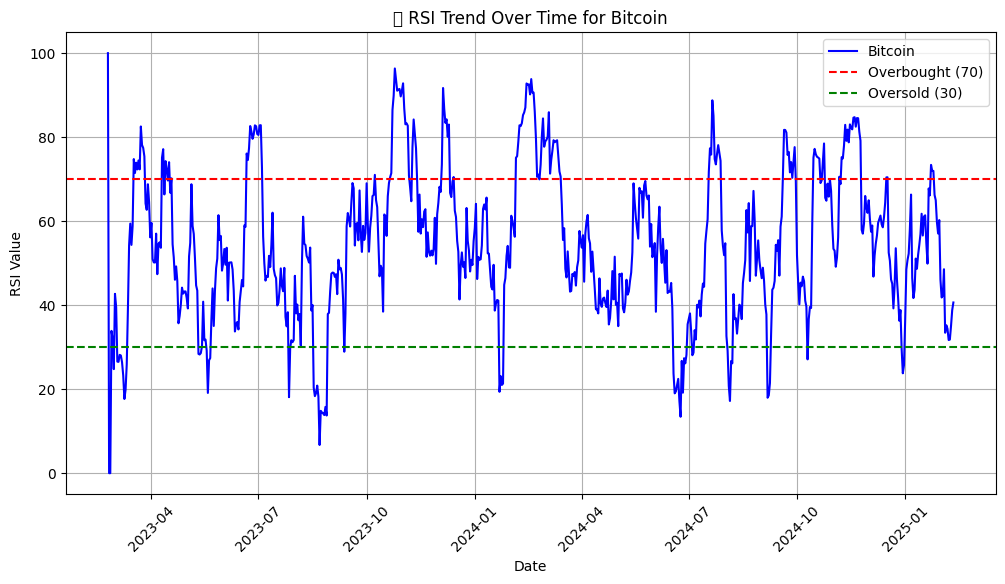

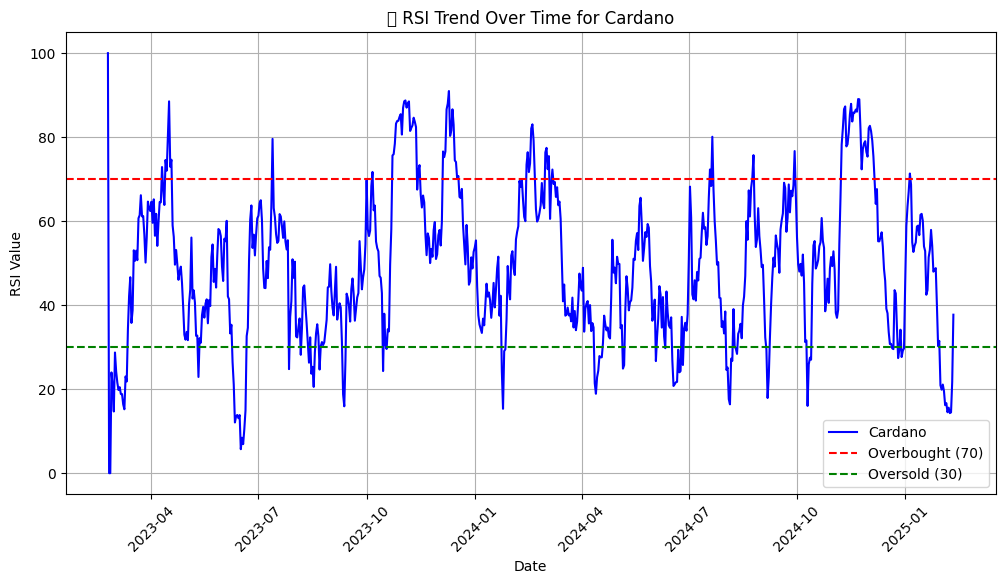

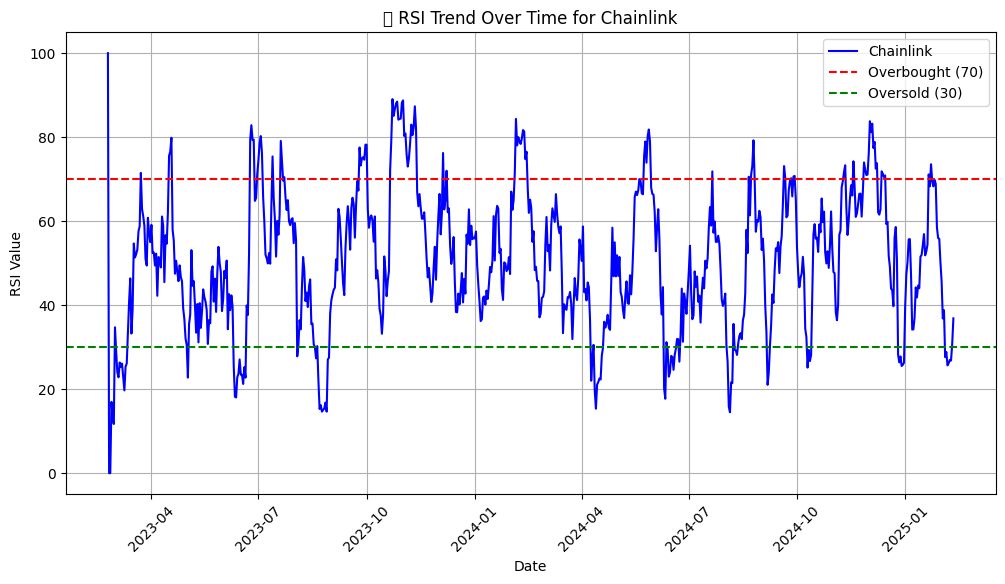

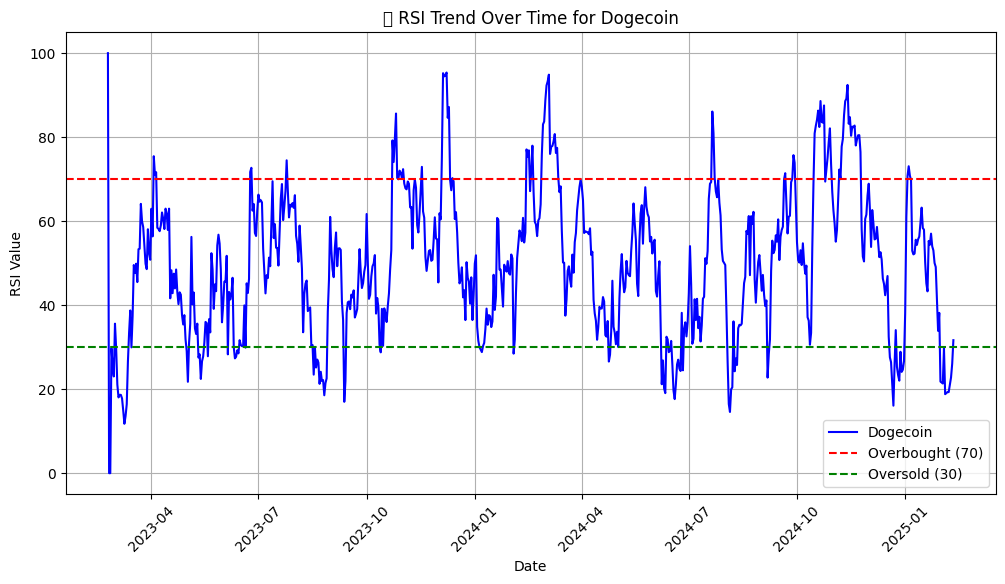

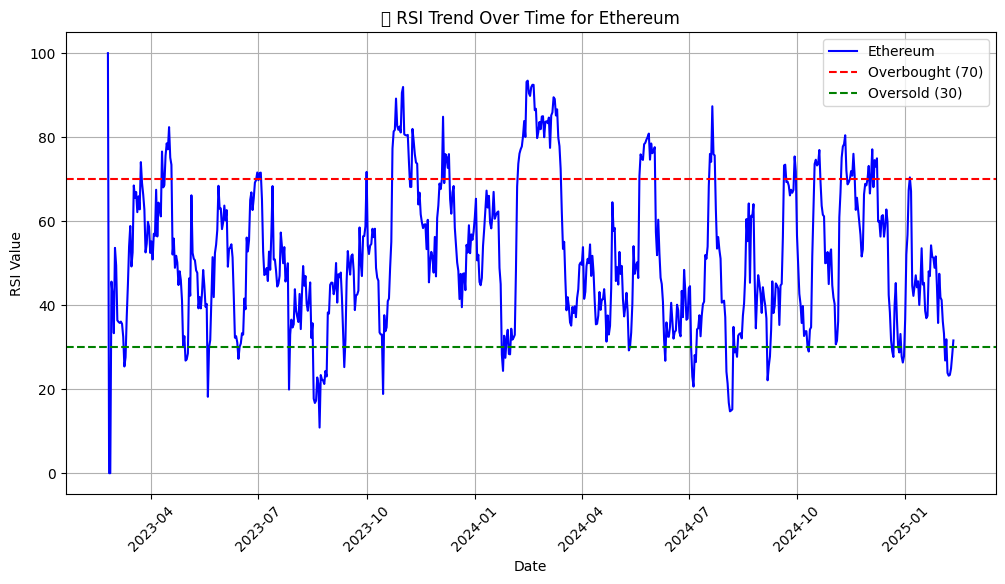

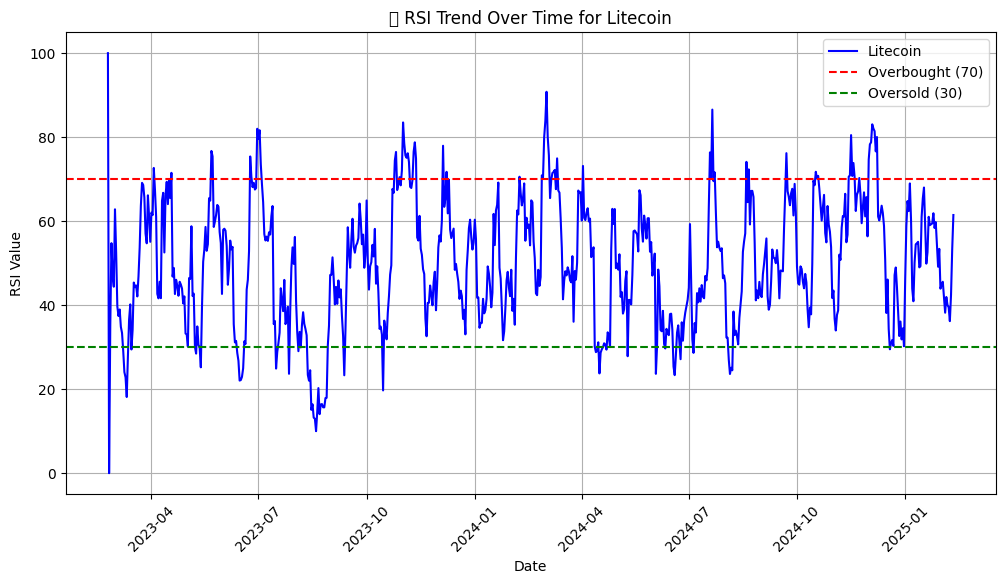

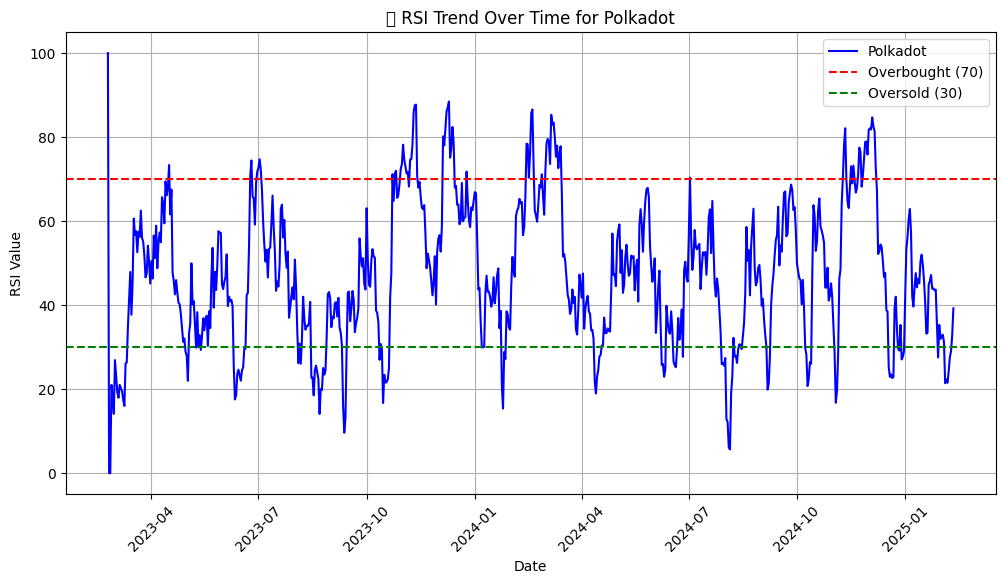

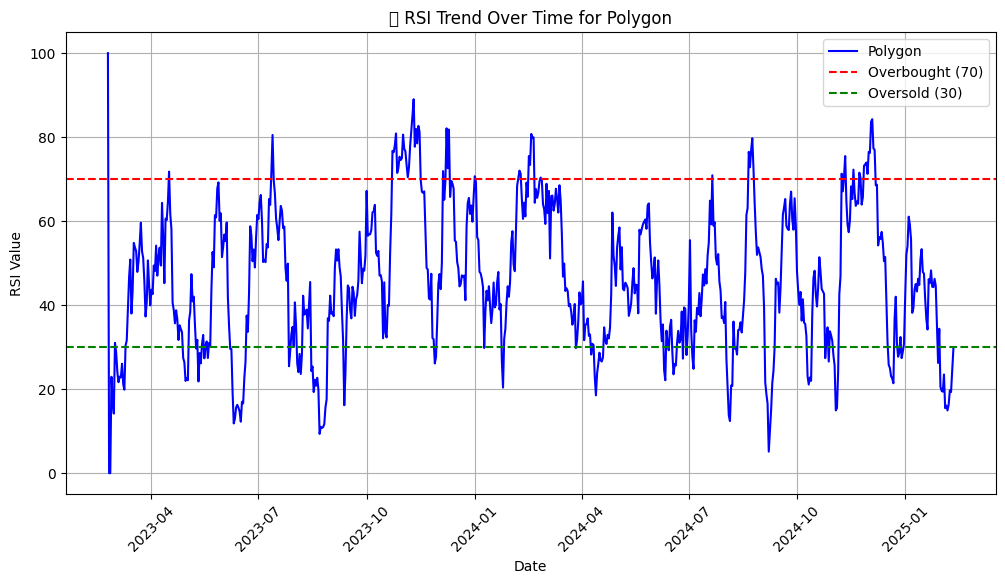

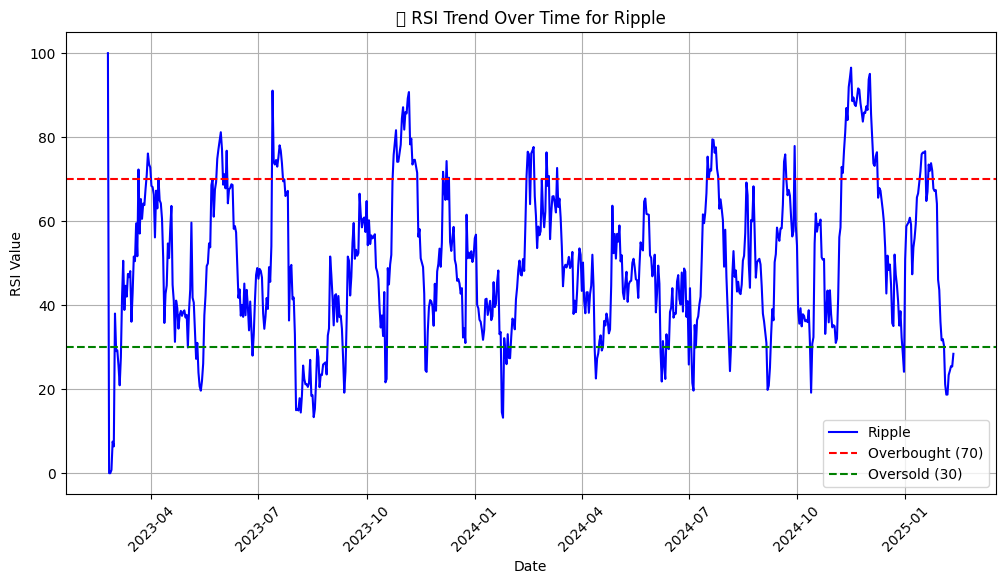

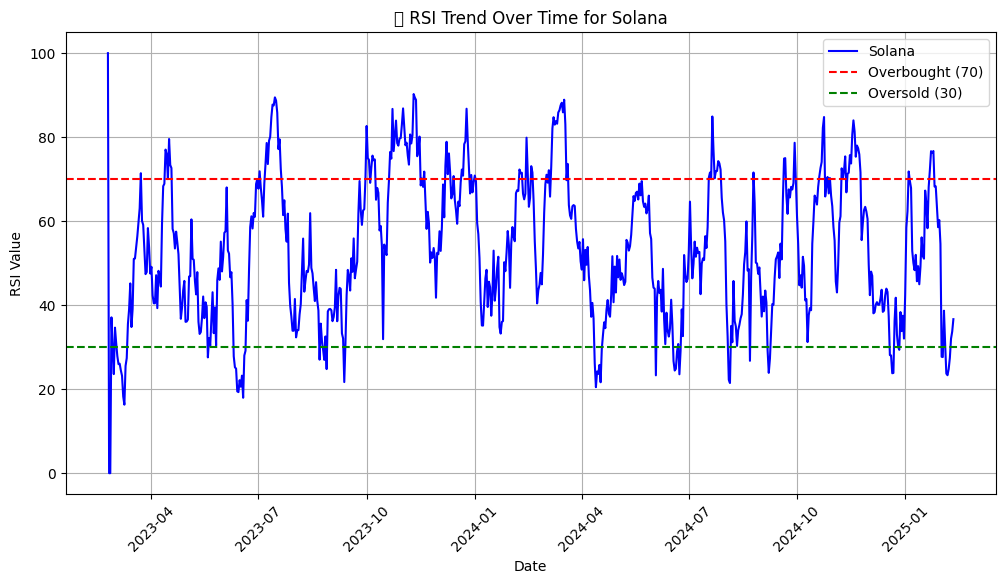

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to Pandas
rsi_df = df.select("Crypto", "Timestamp", "RSI").toPandas()

# Ensure Timestamp is in datetime format
rsi_df["Timestamp"] = pd.to_datetime(rsi_df["Timestamp"])

# Unique Cryptos
cryptos = rsi_df["Crypto"].unique()

# Plot RSI Trend for Each Cryptocurrency
for crypto in cryptos:
    crypto_data = rsi_df[rsi_df["Crypto"] == crypto]

    plt.figure(figsize=(12, 6))
    plt.plot(crypto_data["Timestamp"], crypto_data["RSI"], label=crypto, color="blue")

    # Add Overbought/Oversold Lines
    plt.axhline(70, color='red', linestyle='dashed', label="Overbought (70)")
    plt.axhline(30, color='green', linestyle='dashed', label="Oversold (30)")

    # Chart Labels
    plt.title(f"📈 RSI Trend Over Time for {crypto}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
import plotly.graph_objects as go
from pyspark.sql.functions import col, window, first, last, max, min

# Aggregate data for candlestick chart
candlestick_data = (
    df.groupBy(window(col("Timestamp"), "1 hour"))
    .agg(
        first("Price_Change").alias("Open"),
        max("Price_Change").alias("High"),
        min("Price_Change").alias("Low"),
        last("Price_Change").alias("Close")
    )
    .select(
        col("window.start").alias("Start"),
        col("window.end").alias("End"),
        col("Open"),
        col("High"),
        col("Low"),
        col("Close")
    )
)

# Convert to Pandas for visualization
candlestick_df = candlestick_data.toPandas()

# Plot candlestick chart
fig = go.Figure(
    data=[
        go.Candlestick(
            x=candlestick_df["Start"],
            open=candlestick_df["Open"],
            high=candlestick_df["High"],
            low=candlestick_df["Low"],
            close=candlestick_df["Close"],
            name="Price Change"
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Candlestick Chart of Price Change Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Price Change",
    template="plotly_white"
)

fig.show()

In [ ]:
import plotly.graph_objects as go
from pyspark.sql.functions import col, window, first, last, max, min

# Aggregate data for candlestick chart, grouped by each Crypto and 1-hour interval
candlestick_data = (
    df.groupBy("Crypto", window(col("Timestamp"), "1 hour"))
    .agg(
        first("Open").alias("Open"),
        max("High").alias("High"),
        min("Low").alias("Low"),
        last("Close").alias("Close")
    )
    .select(
        col("Crypto"),
        col("window.start").alias("Start"),
        col("window.end").alias("End"),
        col("Open"),
        col("High"),
        col("Low"),
        col("Close")
    )
)

# Convert to Pandas for visualization
candlestick_df = candlestick_data.toPandas()

# Iterate through each cryptocurrency and plot its candlestick chart
unique_cryptos = candlestick_df["Crypto"].unique()

for crypto in unique_cryptos:
    crypto_data = candlestick_df[candlestick_df["Crypto"] == crypto]

    fig = go.Figure(
        data=[
            go.Candlestick(
                x=crypto_data["Start"],
                open=crypto_data["Open"],
                high=crypto_data["High"],
                low=crypto_data["Low"],
                close=crypto_data["Close"],
                name=f"{crypto} Prices"
            )
        ]
    )

    # Customize layout
    fig.update_layout(
        title=f"Candlestick Chart for {crypto}",
        xaxis_title="Timestamp",
        yaxis_title="Price",
        template="plotly_white"
    )

    fig.show()

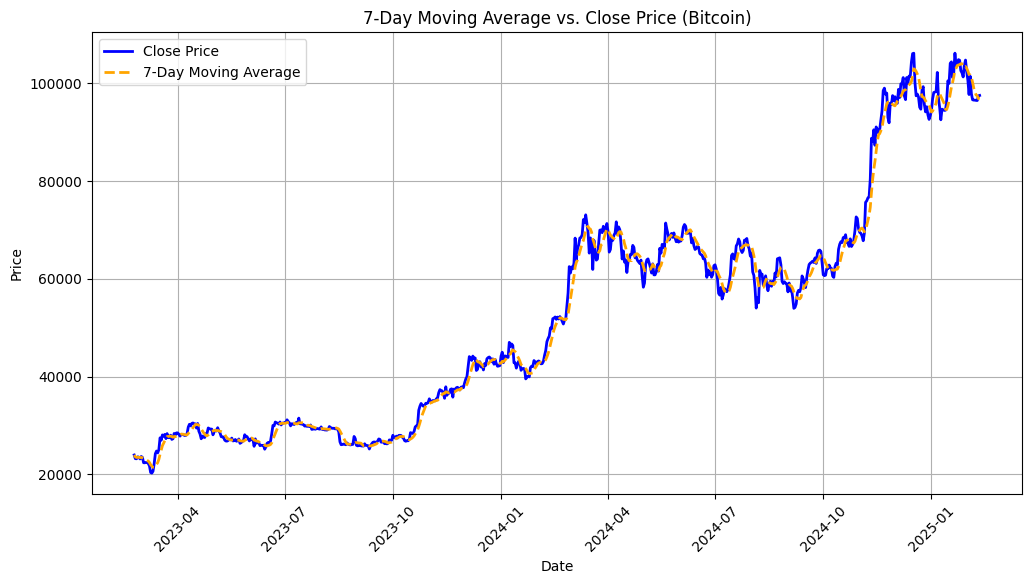

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
data_pd = df.select("Crypto", "Timestamp", "Close", "MA_7", "MA_14").toPandas()

# Filter the data for Bitcoin (or another crypto of your choice)
data_filtered = data_pd[data_pd["Crypto"] == "Bitcoin"]

# Plot Closing Price and 7-day Moving Average
plt.figure(figsize=(12, 6))
plt.plot(data_filtered["Timestamp"], data_filtered["Close"], label="Close Price", color="blue", linewidth=2)
plt.plot(data_filtered["Timestamp"], data_filtered["MA_7"], label="7-Day Moving Average", color="orange", linestyle="dashed", linewidth=2)

# Formatting the plot
plt.title("7-Day Moving Average vs. Close Price (Bitcoin)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

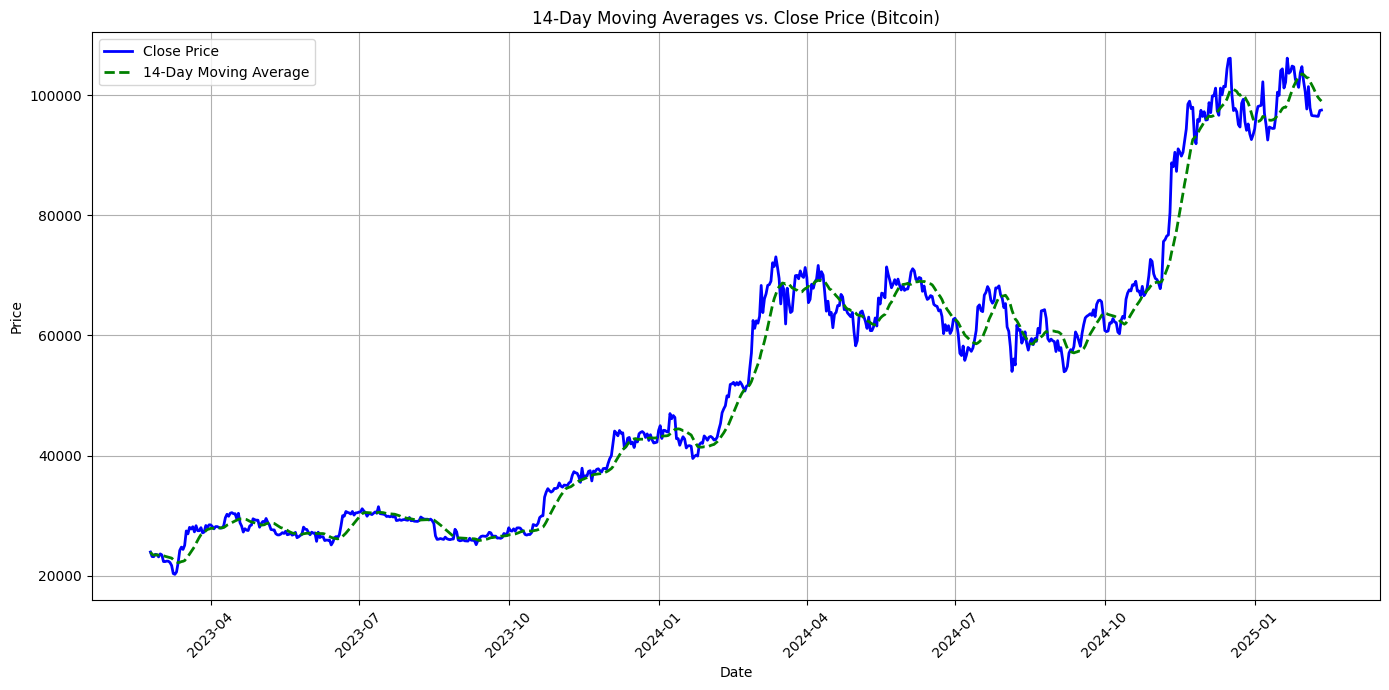

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
data_pd = df.select("Crypto", "Timestamp", "Close", "MA_14").toPandas()

# Filter the data for Bitcoin (or another crypto of your choice)
data_filtered = data_pd[data_pd["Crypto"] == "Bitcoin"]

# Plot Closing Price, 7-day MA, and 14-day MA
plt.figure(figsize=(14, 7))
plt.plot(data_filtered["Timestamp"], data_filtered["Close"], label="Close Price", color="blue", linewidth=2)
plt.plot(data_filtered["Timestamp"], data_filtered["MA_14"], label="14-Day Moving Average", color="green", linestyle="dashed", linewidth=2)

# Formatting the plot
plt.title("14-Day Moving Averages vs. Close Price (Bitcoin)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

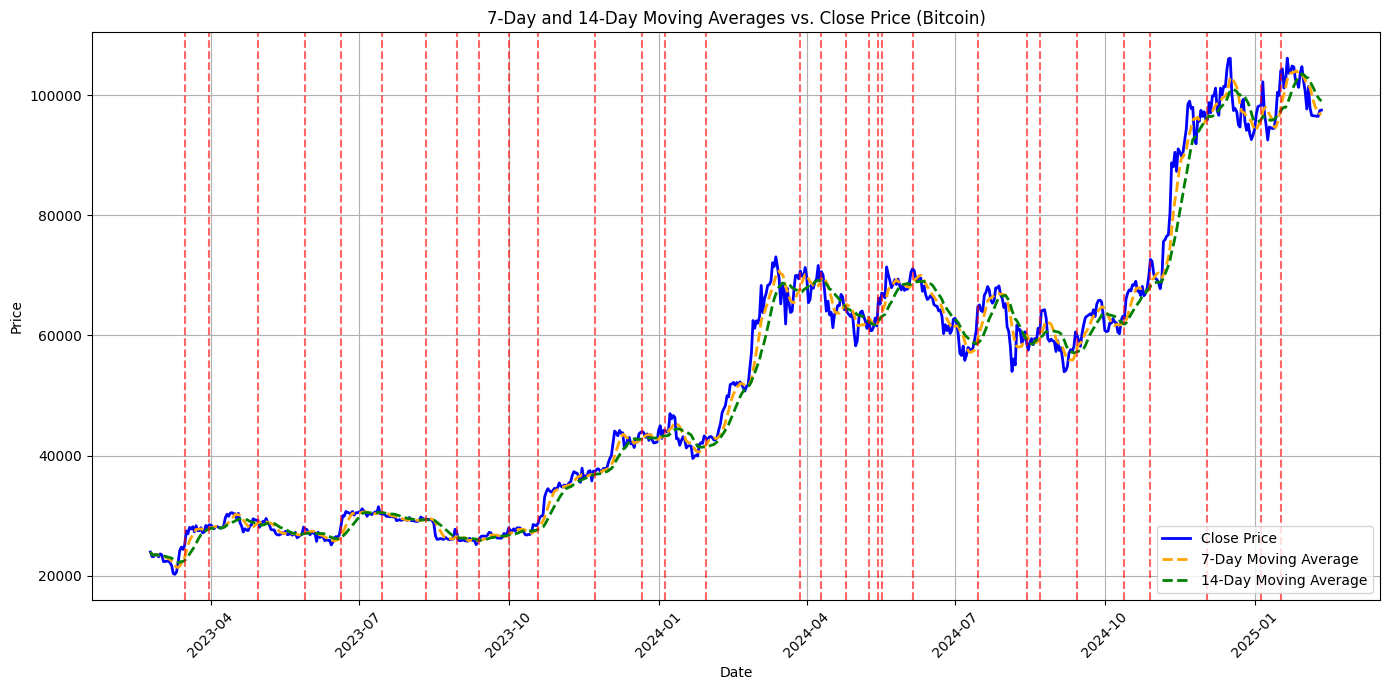

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
data_pd = df.select("Crypto", "Timestamp", "Close", "MA_7", "MA_14").toPandas()

# Filter the data for Bitcoin
data_filtered = data_pd[data_pd["Crypto"] == "Bitcoin"]



# Plot Closing Price, 7-day MA, and 14-day MA
plt.figure(figsize=(14, 7))
plt.plot(data_filtered["Timestamp"], data_filtered["Close"], label="Close Price", color="blue", linewidth=2)
plt.plot(data_filtered["Timestamp"], data_filtered["MA_7"], label="7-Day Moving Average", color="orange", linestyle="dashed", linewidth=2)
plt.plot(data_filtered["Timestamp"], data_filtered["MA_14"], label="14-Day Moving Average", color="green", linestyle="dashed", linewidth=2)

crossover = data_filtered[(data_filtered["MA_7"] > data_filtered["MA_14"]) & (data_filtered["MA_7"].shift(1) <= data_filtered["MA_14"].shift(1))]
for _, row in crossover.iterrows():
    plt.axvline(x=row["Timestamp"], color="red", linestyle="--", alpha=0.6)

# Formatting the plot
plt.title("7-Day and 14-Day Moving Averages vs. Close Price (Bitcoin)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Zoom into Specific Time Periods

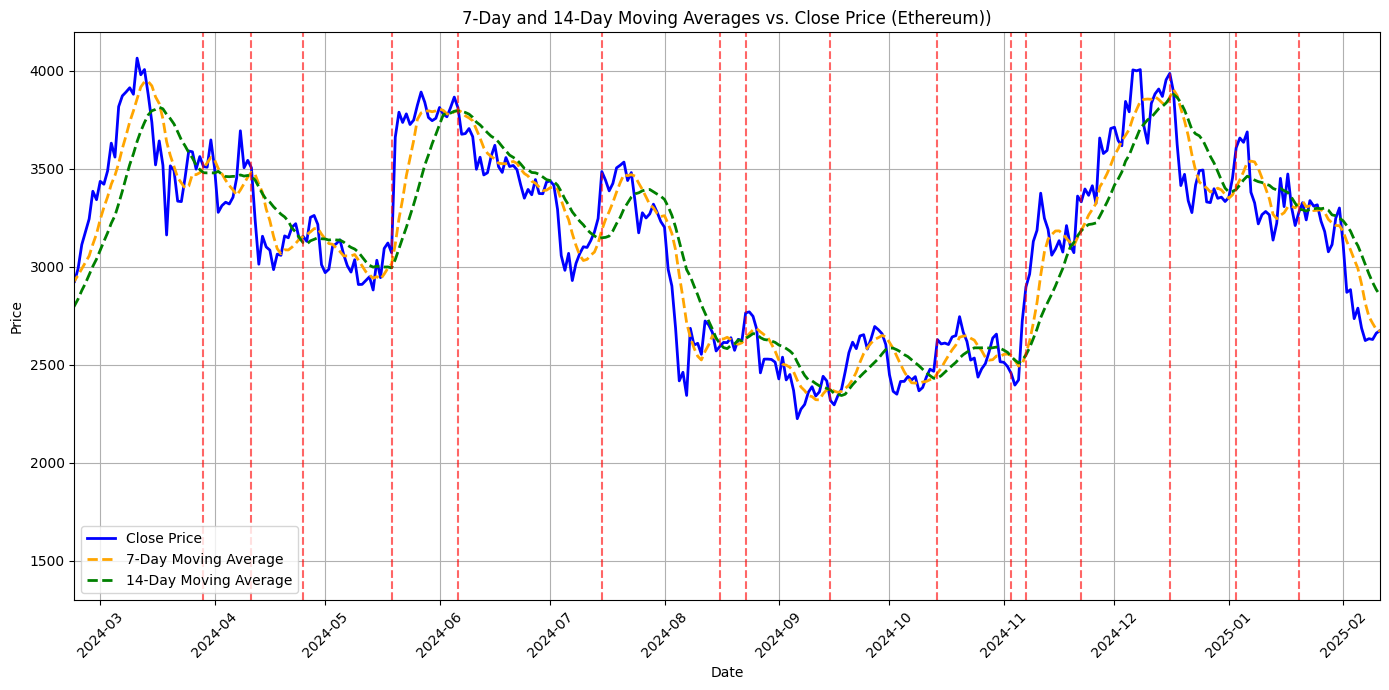

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
data_pd = df.select("Crypto", "Timestamp", "Close", "MA_7", "MA_14").toPandas()

# Filter the data for Bitcoin
data_filtered = data_pd[data_pd["Crypto"] == "Ethereum"]



# Plot Closing Price, 7-day MA, and 14-day MA
plt.figure(figsize=(14, 7))
plt.plot(data_filtered["Timestamp"], data_filtered["Close"], label="Close Price", color="blue", linewidth=2)
plt.plot(data_filtered["Timestamp"], data_filtered["MA_7"], label="7-Day Moving Average", color="orange", linestyle="dashed", linewidth=2)
plt.plot(data_filtered["Timestamp"], data_filtered["MA_14"], label="14-Day Moving Average", color="green", linestyle="dashed", linewidth=2)

crossover = data_filtered[(data_filtered["MA_7"] > data_filtered["MA_14"]) & (data_filtered["MA_7"].shift(1) <= data_filtered["MA_14"].shift(1))]
for _, row in crossover.iterrows():
    plt.axvline(x=row["Timestamp"], color="red", linestyle="--", alpha=0.6)

plt.xlim(pd.Timestamp("2024-02-23"), pd.Timestamp("2025-02-11"))


# Formatting the plot
plt.title("7-Day and 14-Day Moving Averages vs. Close Price (Ethereum))")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()